# Problem Formation

Given a Pattern String as an input, we want to know if it contains dark pattern in it. We use a balanced dataset cotaining all the instances in the Princeton dataset which are all dark patterns, and the instances in the 'normie.csv' file which are labeled as NOT dark patterns. Hence we have a balanced dataset consisting of pattern strings with dark pattern and without park patterns.

Then we use this labeled dataset to build and train supervised machine learning models, and select most suitable ones for our project.

----


In [1]:
import pandas as pd 
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

# provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words, but also to encode new documents using that vocabulary.
from sklearn.feature_extraction.text import TfidfVectorizer

# Bernoulli Naive Bayes (Similar as  MultinomialNB), this classifier is suitable for discrete data. The difference between MultinomialNB and BernoulliNB is that while  MultinomialNB works with occurrence counts, BernoulliNB is designed for binary/boolen features, which means in the case of text classification, word occurrence vectores (rather than word count vectors) may be more suitable to be used to train and use this classifier.
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

# Evaluation metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score

# joblib is a set of tools to provide lightweight pipelining in Python. It provides utilities for saving and loading Python objects that make use of NumPy data structures, efficiently.
import joblib

import matplotlib.pyplot as plt
# import seaborn as sns

## Data Exploration

---
Import the merged dataset, and explore the dataset.

In [2]:
data = pd.read_csv('enriched_confirm.csv')

In [3]:
data.head(5)

Pattern String classification
0  Ends in 07:42:09       Not_Dark
1  Ends in 07:37:10       Not_Dark
2  Ends in 02:27:10       Not_Dark
3  Ends in 04:17:10       Not_Dark
4  Ends in 01:57:10       Not_Dark

---
`check the dataset information`

There are 7952 NOT NULL instances of pattern strings in the dataset.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8187 entries, 0 to 8186
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Pattern String  8187 non-null   object
 1   classification  8187 non-null   object
dtypes: object(2)
memory usage: 128.0+ KB


In [5]:
# check the distribution of the target value --- classification.

print('Distribution of the tags:\n{}'.format(data['classification'].value_counts()))

Distribution of the tags:
Not_Dark    7994
Dark         193
Name: classification, dtype: int64


In [6]:
# Change the content into lowercase

data['Pattern String'] = data['Pattern String'].str.lower()

In [7]:
# For later training the model, we should remove the duplicate input to reduce overfitting.

data = data.drop_duplicates(subset="Pattern String")

print('\nDistribution of the tags:\n{}'.format(data['classification'].value_counts()))


Distribution of the tags:
Not_Dark    7755
Dark         180
Name: classification, dtype: int64


In [8]:
data.head(5)

Pattern String classification
0  ends in 07:42:09       Not_Dark
1  ends in 07:37:10       Not_Dark
2  ends in 02:27:10       Not_Dark
3  ends in 04:17:10       Not_Dark
4  ends in 01:57:10       Not_Dark

<AxesSubplot:xlabel='classification'>

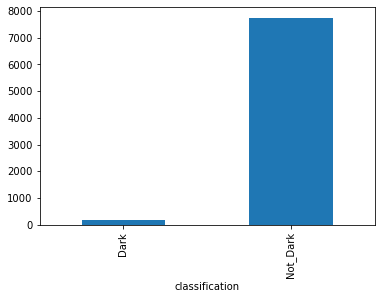

In [9]:
# plot the distribution graph

target = data.groupby('classification')['classification'].count()
target.plot.bar()

---
## Data Preparation

In [10]:
# split the dataset into train and test dataset as a ratio of 80%/20% (train/test).

string_train, string_test, dark_train, dark_test = train_test_split(
    data['Pattern String'], data["classification"], train_size = .8)

---
`Encode the target vales into integers` --- 'classification'

In [11]:
encoder = LabelEncoder()
encoder.fit(dark_train)
y_train = encoder.transform(dark_train)
y_test = encoder.transform(dark_test)

In [12]:
# check the mapping of encoding results (from 0 to 1 representing 'Dark', 'Not Dark')

integer_mapping = {label: encoding for encoding, label in enumerate(encoder.classes_)}
print(integer_mapping)

{'Dark': 0, 'Not_Dark': 1}


In [13]:
# Check the frequency distribution of the training pattern classification with pattern classification names.

(unique, counts) = np.unique(dark_train, return_counts=True)
frequencies = np.asarray((unique, counts)).T

print(frequencies)

[['Dark' 155]
 ['Not_Dark' 6193]]


In [14]:
# Check the frequency distribution of the encoded training pattern classification with encoded integers.

(unique, counts) = np.unique(y_train, return_counts=True)
frequencies = np.asarray((unique, counts)).T

print(frequencies)

[[   0  155]
 [   1 6193]]


In [15]:
# Check the frequency distribution of the encoded testing pattern classification with encoded integers.

(unique, counts) = np.unique(y_test, return_counts=True)
frequencies = np.asarray((unique, counts)).T

print(frequencies)

[[   0   25]
 [   1 1562]]


---
`Encode the textual features into series of vector of numbers`

In [16]:
# get the word count vector of the pattern string to encode the pattern string.

tv = TfidfVectorizer()
tv.fit(string_train)

x_train = tv.transform(string_train)
x_test = tv.transform(string_test)

x_train.shape, x_test.shape

((6348, 5595), (1587, 5595))

In [17]:
# save the CountVectorizer to disk

joblib.dump(tv, 'presence_TfidfVectorizer.joblib')

['presence_TfidfVectorizer.joblib']

------
## RandomOverSampler

Random versampling involves randomly duplicating examples from the minority class and adding them to the training dataset.

In [18]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy = 'minority', random_state = 22)

x_train_ros, y_train_ros = ros.fit_resample(x_train,y_train)

In [19]:
type(x_train_ros), x_train_ros.shape, type(y_train_ros), y_train_ros.shape

(scipy.sparse.csr.csr_matrix, (12386, 5595), numpy.ndarray, (12386,))

In [20]:
# Check the frequency distribution of the encoded training pattern classification with encoded integers.

(unique, counts) = np.unique(y_train_ros, return_counts=True)
frequencies = np.asarray((unique, counts)).T

print(frequencies)

[[   0 6193]
 [   1 6193]]


---
# Rough Idea about the effect of different classifiers
---

In [21]:
# Four models are tested:
# -- Logistic Regression
# -- Linear Support Vector Machine
# -- Random Forest
# -- Bernoulli Naive Bayes

classifiers = [LogisticRegression(), LinearSVC(), RandomForestClassifier(), BernoulliNB()]

------
### `Using Not Oversampled Training Data`


In [22]:
# Calculate the accuracies of different classifiers using default settings.

acc = []
pre = []
cm = []

for clf in classifiers:
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    acc.append(metrics.accuracy_score(y_test, y_pred))
    pre.append(metrics.precision_score(y_test, y_pred, pos_label=0))
    cm.append(metrics.confusion_matrix(y_test, y_pred))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
# List the accuracies of different classifiers.

for i in range(len(classifiers)):
    print("{} accuracy: {:.3f}".format(classifiers[i],acc[i]))
    print("{} precision: {:.3f}".format(classifiers[i],pre[i]))
    print("Confusion Matrix: {}".format(cm[i]))

LogisticRegression() accuracy: 0.995
LogisticRegression() precision: 1.000
Confusion Matrix: [[  17    8]
 [   0 1562]]
LinearSVC() accuracy: 0.997
LinearSVC() precision: 0.920
Confusion Matrix: [[  23    2]
 [   2 1560]]
RandomForestClassifier() accuracy: 0.997
RandomForestClassifier() precision: 1.000
Confusion Matrix: [[  21    4]
 [   0 1562]]
BernoulliNB() accuracy: 0.984
BernoulliNB() precision: 0.000
Confusion Matrix: [[   0   25]
 [   0 1562]]


-------
### `Using Oversampled Training Data`


In [24]:
# Calculate the accuracies of different classifiers using default settings.

acc = []
pre = []
cm = []

for clf in classifiers:
    clf.fit(x_train_ros, y_train_ros)
    y_pred = clf.predict(x_test)
    acc.append(metrics.accuracy_score(y_test, y_pred))
    pre.append(metrics.precision_score(y_test, y_pred, pos_label=0))
    cm.append(metrics.confusion_matrix(y_test, y_pred))

In [25]:
# List the accuracies of different classifiers.

for i in range(len(classifiers)):
    print("{} accuracy: {:.3f}".format(classifiers[i],acc[i]))
    print("{} precision: {:.3f}".format(classifiers[i],pre[i]))
    print("Confusion Matrix: {}".format(cm[i]))

LogisticRegression() accuracy: 0.997
LogisticRegression() precision: 0.889
Confusion Matrix: [[  24    1]
 [   3 1559]]
LinearSVC() accuracy: 0.996
LinearSVC() precision: 0.828
Confusion Matrix: [[  24    1]
 [   5 1557]]
RandomForestClassifier() accuracy: 0.999
RandomForestClassifier() precision: 0.960
Confusion Matrix: [[  24    1]
 [   1 1561]]
BernoulliNB() accuracy: 0.990
BernoulliNB() precision: 0.610
Confusion Matrix: [[  25    0]
 [  16 1546]]


---
# Bernoulli Naive Bayes Classifier


---
### `Use default setting of classifier hyperparameters`

In [26]:
clf_bnb = BernoulliNB().fit(x_train_ros, y_train_ros)

y_pred = clf_bnb.predict(x_test)

In [27]:
clf_bnb.get_params()

{'alpha': 1.0, 'binarize': 0.0, 'class_prior': None, 'fit_prior': True}

---
`use the default setting of hyperparameters of the Bernoulli Naive Bayes classifier`

In [28]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test,y_pred, pos_label=0))
print("Confusion Matrix:\n", metrics.confusion_matrix(y_test, y_pred))

Accuracy: 0.9899180844360429
Precision: 0.6097560975609756
Confusion Matrix:
 [[  25    0]
 [  16 1546]]


In [29]:
(unique, counts) = np.unique(y_pred, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

array([[   0,   41],
       [   1, 1546]])

---
### `Parameter Tunning of BernoulliNB classifier`
`Define the combination of parameters to be considered`

In [30]:
param_grid = {'alpha':[0,1], 
              'fit_prior':[True, False]}

`Run the Grid Search`

Use cross validation on the training dataset to find optimal model.

In [31]:
gs = GridSearchCV(clf_bnb,param_grid,cv=5, 
                      verbose = 1, n_jobs = -1)

In [32]:
best_bnb = gs.fit(x_train_ros,y_train_ros)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


In [33]:
scores_df = pd.DataFrame(best_bnb.cv_results_)
scores_df = scores_df.sort_values(by=['rank_test_score']).reset_index(drop='index')
scores_df [['rank_test_score', 'mean_test_score', 'param_alpha', 'param_fit_prior']]

rank_test_score  mean_test_score param_alpha param_fit_prior
0                1         0.997255           0            True
1                1         0.997255           0           False
2                3         0.994914           1            True
3                3         0.994914           1           False

In [34]:
best_bnb.best_params_

{'alpha': 0, 'fit_prior': True}

In [35]:
y_pred_best = best_bnb.predict(x_test)

(unique, counts) = np.unique(y_pred_best, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

[[   0   29]
 [   1 1558]]


In [36]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred_best))
print("Precision:", metrics.precision_score(y_test,y_pred_best, pos_label=0))
print("Confusion Matrix:\n", metrics.confusion_matrix(y_test, y_pred_best))

Accuracy: 0.9911783238815375
Precision: 0.6896551724137931
Confusion Matrix:
 [[  20    5]
 [   9 1553]]


---
`Save the best BernoulliNB model for future use`

In [37]:
# save the model to local disk

joblib.dump(best_bnb, 'bnb_presence_classifier.joblib')

['bnb_presence_classifier.joblib']

---
# SVM Classifier


---
### `Use default setting of classifier hyperparameters`

In [38]:
clf_svm = LinearSVC().fit(x_train_ros,y_train_ros)

y_pred = clf_svm.predict(x_test)

In [39]:
clf_svm.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 1000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

---
`use the default setting of hyperparameters of the Random Forest classifier.`

In [40]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test,y_pred, pos_label=0))
print("Confusion Matrix:\n", metrics.confusion_matrix(y_test, y_pred))

Accuracy: 0.996219281663516
Precision: 0.8275862068965517
Confusion Matrix:
 [[  24    1]
 [   5 1557]]


In [41]:
(unique, counts) = np.unique(y_pred, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

array([[   0,   29],
       [   1, 1558]])

---
### `Parameter Tunning of SVM classifier`
`Define the combination of parameters to be considered`

In [42]:
param_grid = {'C':[0.1,1,10,100],
              'penalty':['l1','l2']}

`Run the Grid Search`

Use cross validation on the training dataset to find optimal model.

In [43]:
gs = GridSearchCV(clf_svm,param_grid,cv=5, 
                      verbose = 1, n_jobs = -1)

In [44]:
best_svm = gs.fit(x_train_ros,y_train_ros)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py", line 1185, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(mult

In [45]:
scores_df = pd.DataFrame(best_svm.cv_results_)
scores_df = scores_df.sort_values(by=['rank_test_score']).reset_index(drop='index')
scores_df [['rank_test_score', 'mean_test_score', 'param_penalty', 'param_C']]

rank_test_score  mean_test_score param_penalty param_C
0                1         0.999516            l2      10
1                2         0.999435            l2       1
2                3         0.999354            l2     100
3                4         0.999193            l2     0.1
4                5              NaN            l1     0.1
5                6              NaN            l1       1
6                7              NaN            l1      10
7                8              NaN            l1     100

In [46]:
best_svm.best_params_

{'C': 10, 'penalty': 'l2'}

In [47]:
y_pred_best = best_svm.predict(x_test)

(unique, counts) = np.unique(y_pred_best, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

[[   0   25]
 [   1 1562]]


In [48]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred_best))
print("Precision:", metrics.precision_score(y_test,y_pred_best, pos_label=0))
print("Confusion Matrix:\n", metrics.confusion_matrix(y_test, y_pred_best))

Accuracy: 0.9974795211090107
Precision: 0.92
Confusion Matrix:
 [[  23    2]
 [   2 1560]]


---
`Save the best SVM model for future use`

In [49]:
# save the model to local disk

joblib.dump(best_svm, 'svm_presence_classifier.joblib')

['svm_presence_classifier.joblib']

---
# Logistic Regression Classifier


---
### `Use default setting of classifier hyperparameters`

In [50]:
clf_lr = LogisticRegression().fit(x_train_ros, y_train_ros)

y_pred = clf_lr.predict(x_test)

In [51]:
clf_lr.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

---
`use the default setting of hyperparameters of the Logistic Regression classifier.`

In [52]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test,y_pred, pos_label=0))
print("Confusion Matrix:\n", metrics.confusion_matrix(y_test, y_pred))

Accuracy: 0.9974795211090107
Precision: 0.8888888888888888
Confusion Matrix:
 [[  24    1]
 [   3 1559]]


In [53]:
(unique, counts) = np.unique(y_pred, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

array([[   0,   27],
       [   1, 1560]])

---
### `Parameter Tunning of Logistic Regression classifier`
`Define the combination of parameters to be considered`

In [54]:
param_grid = {'penalty':['l1','l2'], 
              'solver':['lbfgs','newton-cg','sag']}

`Run the Grid Search`

Use cross validation on the training dataset to find optimal model.

In [55]:
gs = GridSearchCV(clf_lr,param_grid,cv=5, 
                      verbose = 1, n_jobs = -1)

In [56]:
best_lr = gs.fit(x_train_ros,y_train_ros)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 447, in _check_solver
    raise ValueError(
Value

In [57]:
scores_df = pd.DataFrame(best_lr.cv_results_)
scores_df = scores_df.sort_values(by=['rank_test_score']).reset_index(drop='index')
scores_df [['rank_test_score', 'mean_test_score', 'param_penalty', 'param_solver']]

rank_test_score  mean_test_score param_penalty param_solver
0                1         0.999193            l2        lbfgs
1                1         0.999193            l2    newton-cg
2                1         0.999193            l2          sag
3                4              NaN            l1        lbfgs
4                5              NaN            l1    newton-cg
5                6              NaN            l1          sag

In [58]:
best_lr.best_params_

{'penalty': 'l2', 'solver': 'lbfgs'}

In [59]:
y_pred_best = best_lr.predict(x_test)

(unique, counts) = np.unique(y_pred_best, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

[[   0   27]
 [   1 1560]]


In [60]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred_best))
print("Precision:", metrics.precision_score(y_test,y_pred_best, pos_label=0))
print("Confusion Matrix:\n", metrics.confusion_matrix(y_test, y_pred_best))

Accuracy: 0.9974795211090107
Precision: 0.8888888888888888
Confusion Matrix:
 [[  24    1]
 [   3 1559]]


---
`Save the best Logistic Regression model for future use`

In [61]:
# save the model to local disk

joblib.dump(best_lr, 'lr_presence_classifier.joblib')

['lr_presence_classifier.joblib']

---
# Random Forest Classifier


---
### `Use default setting of classifier hyperparameters`

In [62]:
clf_rf = RandomForestClassifier().fit(x_train_ros, y_train_ros)

y_pred = clf_rf.predict(x_test)

In [63]:
clf_rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

---
`use the default setting of hyperparameters of the Random Forest classifier.`

In [64]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test,y_pred, pos_label=0))
print("Confusion Matrix:\n", metrics.confusion_matrix(y_test, y_pred))

Accuracy: 0.998109640831758
Precision: 0.9583333333333334
Confusion Matrix:
 [[  23    2]
 [   1 1561]]


In [65]:
(unique, counts) = np.unique(y_pred, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

array([[   0,   24],
       [   1, 1563]])

---
### `Parameter Tunning of Random Forest classifier`
`Define the combination of parameters to be considered`

In [66]:
param_grid = {'bootstrap':[True,False], 
              'criterion':['gini','entropy'],
              'max_depth':[10,20,30,40,50, None],
              'min_samples_leaf':[1,2,4],
              'min_samples_split':[2,5,10],
              'n_estimators':[100,200,300]}

`Run the Grid Search`

Use cross validation on the training dataset to find optimal model.

In [67]:
gs = GridSearchCV(clf_rf,param_grid,cv=5, 
                      verbose = 1, n_jobs = -1)

In [68]:
best_rf = gs.fit(x_train_ros,y_train_ros)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


In [69]:
scores_df = pd.DataFrame(best_rf.cv_results_)
scores_df = scores_df.sort_values(by=['rank_test_score']).reset_index(drop='index')
scores_df [['rank_test_score', 'mean_test_score', 'param_bootstrap', 'param_criterion','param_max_depth','param_min_samples_leaf','param_min_samples_split','param_n_estimators']]

rank_test_score  mean_test_score param_bootstrap param_criterion  \
0                  1         0.999758           False            gini   
1                  1         0.999758           False            gini   
2                  1         0.999758           False            gini   
3                  1         0.999758           False            gini   
4                  1         0.999758           False            gini   
..               ...              ...             ...             ...   
643              644         0.954223            True         entropy   
644              645         0.954222            True         entropy   
645              646         0.954142            True         entropy   
646              647         0.953980            True         entropy   
647              648         0.953738            True            gini   

    param_max_depth param_min_samples_leaf param_min_samples_split  \
0              None                      1                       2   
1              None                      1                      10   
2              None                      1                       5   
3              None                      1                       5   
4              None                      1                       5   
..              ...                    ...                     ...   
643              10                      4                      10   
644              10                      4                       5   
645              10                      1                      10   
646              10                      2                       5   
647              10                      2                      10   

    param_n_estimators  
0                  300  
1                  100  
2                  300  
3                  200  
4                  100  
..                 ...  
643                100  
644                100  
645                100  
646                100  
647                300  

[648 rows x 8 columns]

In [70]:
best_rf.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [71]:
y_pred_best = best_rf.predict(x_test)

(unique, counts) = np.unique(y_pred_best, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

[[   0   23]
 [   1 1564]]


In [72]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred_best))
print("Precision:", metrics.precision_score(y_test,y_pred_best, pos_label=0))
print("Confusion Matrix:\n", metrics.confusion_matrix(y_test, y_pred_best))

Accuracy: 0.9987397605545053
Precision: 1.0
Confusion Matrix:
 [[  23    2]
 [   0 1562]]


---
`Save the best Random Forest model for future use`

In [73]:
# save the model to local disk

joblib.dump(best_rf, 'rf_presence_classifier.joblib')

['rf_presence_classifier.joblib']

-------
# Check original training data and the oversampled training data

In [74]:
print(x_train)

  (0, 3814)	0.6209198864205403
  (0, 1724)	0.6209198864205403
  (0, 711)	0.4784527032999253
  (1, 1428)	0.5860630138222684
  (1, 655)	0.6279402069519067
  (1, 554)	0.5120754244471769
  (2, 3209)	0.7833595582975206
  (2, 2772)	0.6215688235617304
  (3, 4360)	0.6409061025753301
  (3, 3223)	0.7676192856368973
  (4, 5109)	0.5001218733800556
  (4, 3489)	0.4902705375971136
  (4, 2488)	0.7138017313869874
  (5, 5558)	0.2964270472622959
  (5, 4254)	0.3893557588109906
  (5, 3641)	0.33064028279864144
  (5, 3321)	0.33153594224832833
  (5, 2769)	0.3288883850009415
  (5, 2277)	0.2673178976570813
  (5, 397)	0.44393024647098184
  (5, 156)	0.4057012807378179
  (6, 3413)	0.39338298448433606
  (6, 3110)	0.5803641585820251
  (6, 1573)	0.55639390418779
  (6, 837)	0.4459294723767908
  :	:
  (6345, 5503)	0.5898552773302607
  (6345, 2145)	0.8075089793962921
  (6346, 5024)	0.1463305800730929
  (6346, 4397)	0.1755265133476392
  (6346, 4367)	0.26918728060760844
  (6346, 3993)	0.21347579525791088
  (6346, 3985)	0.

In [75]:
print(x_train_ros)

  (0, 3814)	0.6209198864205403
  (0, 1724)	0.6209198864205403
  (0, 711)	0.4784527032999253
  (1, 1428)	0.5860630138222684
  (1, 655)	0.6279402069519067
  (1, 554)	0.5120754244471769
  (2, 3209)	0.7833595582975206
  (2, 2772)	0.6215688235617304
  (3, 4360)	0.6409061025753301
  (3, 3223)	0.7676192856368973
  (4, 5109)	0.5001218733800556
  (4, 3489)	0.4902705375971136
  (4, 2488)	0.7138017313869874
  (5, 5558)	0.2964270472622959
  (5, 4254)	0.3893557588109906
  (5, 3641)	0.33064028279864144
  (5, 3321)	0.33153594224832833
  (5, 2769)	0.3288883850009415
  (5, 2277)	0.2673178976570813
  (5, 397)	0.44393024647098184
  (5, 156)	0.4057012807378179
  (6, 3413)	0.39338298448433606
  (6, 3110)	0.5803641585820251
  (6, 1573)	0.55639390418779
  (6, 837)	0.4459294723767908
  :	:
  (12379, 3554)	0.4801243903690977
  (12379, 3540)	0.3452862041675192
  (12380, 5022)	0.38846798184234266
  (12380, 3540)	0.36697609003002646
  (12380, 3039)	0.4626225054847734
  (12380, 1840)	0.40680297248613695
  (12380, 